# Bitcoin Price Direction Prediction Project

## Project Overview
This project aims to build a machine learning model to predict the direction of Bitcoin price movements (Up, Down, Sideways).
We will use **XGBoost** as the primary classifier and explore the integration of **Hidden Markov Models (HMM)** to capture market regimes.

## Key Steps:
1.  **Data Analysis**: Demonstrate non-stationarity of prices and failure of simple regression.
2.  **Target Generation**: Create "Oracle" labels using a zero-lag Centered Moving Average.
3.  **Feature Engineering**: Generate a rich set of technical indicators.
4.  **Feature Selection**: Iteratively find the best combination of indicator groups and the optimal number of top features.
5.  **Hyperparameter Tuning**: Use Randomized Search with Walk-Forward Validation to optimize the model.
6.  **Evaluation**: Rigorous testing and visualization of results.


In [ ]:
#!conda install -c conda-forge hmmlearn -y

In [ ]:
#!conda install -c conda-forge statsmodels -y

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_ta as ta
from xgboost import XGBClassifier, XGBRegressor
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, r2_score
from sklearn.preprocessing import RobustScaler
from hmmlearn.hmm import GaussianHMM
from scipy.ndimage import gaussian_filter1d
from statsmodels.tsa.stattools import adfuller
import warnings
import os

# Settings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
plt.style.use('seaborn-v0_8-darkgrid')


C:\_PYTH\_ANACONDA\envs\xgb_fints_project\lib\site-packages\pandas_ta\__init__.py:7: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


In [2]:
def load_and_merge_data(
    fundings_path: str = "data/processed/fundings.parquet",
    klines_path: str = "data/processed/klines_15min_all.parquet",
    volumes_path: str = "data/processed/aggtrades_15min_all.parquet",
) -> pd.DataFrame:
    """Loads and merges funding, klines, and volume data."""
    print("Loading data...")
    fundings = pd.read_parquet(fundings_path)
    klines = pd.read_parquet(klines_path)
    volumes = pd.read_parquet(volumes_path)

    if "datetime" in volumes.columns: volumes = volumes.rename(columns={"datetime": "time"})
    if "calc_time" in fundings.columns: fundings = fundings.rename(columns={"calc_time": "time"})
    if "open_time" in klines.columns: klines = klines.rename(columns={"open_time": "time"})

    for col in ["time"]:
        volumes[col] = pd.to_datetime(volumes[col], utc=True)
        fundings[col] = pd.to_datetime(fundings[col], utc=True)
        klines[col] = pd.to_datetime(klines[col], utc=True)

    df = pd.merge(volumes, klines, on="time", how="inner")
    df = pd.merge(df, fundings, on="time", how="left")

    df = df.sort_values("time").reset_index(drop=True)
    if "funding_rate" in df.columns:
        df["funding_rate"] = df["funding_rate"].ffill()
    
    print(f"Data loaded successfully. Shape: {df.shape}")
    return df


In [3]:
# Load the data
df = load_and_merge_data()
print(df.head())


Loading data...
Data loaded successfully. Shape: (64320, 16)
                       time  total_vol   bid_vol  max_bid_vol  mod_bid_vol  \
0 2024-01-01 00:00:00+00:00   3616.424  1254.573       50.010        0.003   
1 2024-01-01 00:15:00+00:00   2322.028  1229.331       39.160        0.003   
2 2024-01-01 00:30:00+00:00   1684.217   879.438       20.174        0.003   
3 2024-01-01 00:45:00+00:00    835.244   408.159       15.407        0.003   
4 2024-01-01 01:00:00+00:00    850.274   482.286       50.858        0.003   

   avg_bid_vol   ask_vol  max_ask_vol  mod_ask_vol  avg_ask_vol     open  \
0     0.118133  2361.851       73.934        0.003     0.222397  42314.0   
1     0.145707  1092.697       30.074        0.003     0.129513  42532.4   
2     0.136326   804.779       14.077        0.003     0.124753  42458.4   
3     0.117625   427.085       18.973        0.003     0.123079  42474.5   
4     0.140077   367.988       16.992        0.003     0.106880  42503.5   

      high   

# 1. Data Analysis: Stationarity & Regression Failure

### 1.1 Stationarity Check

Financial time series like Bitcoin prices are typically non-stationary (mean and variance change over time), making them unsuitable for direct prediction using many statistical models. Log-returns are usually stationary.

We will use the **Augmented Dickey-Fuller (ADF)** test to statistically prove this.


--- ADF Test for Close Price ---
ADF Statistic: -0.9890
p-value: 0.7573
Critical Values:
	1%: -3.4310
	5%: -2.8618
	10%: -2.5669
Result: Close Price is NON-STATIONARY (Fail to reject H0)


--- ADF Test for Log Returns ---
ADF Statistic: -32.4312
p-value: 0.0000
Critical Values:
	1%: -3.4310
	5%: -2.8618
	10%: -2.5669
Result: Log Returns is STATIONARY (Reject H0)




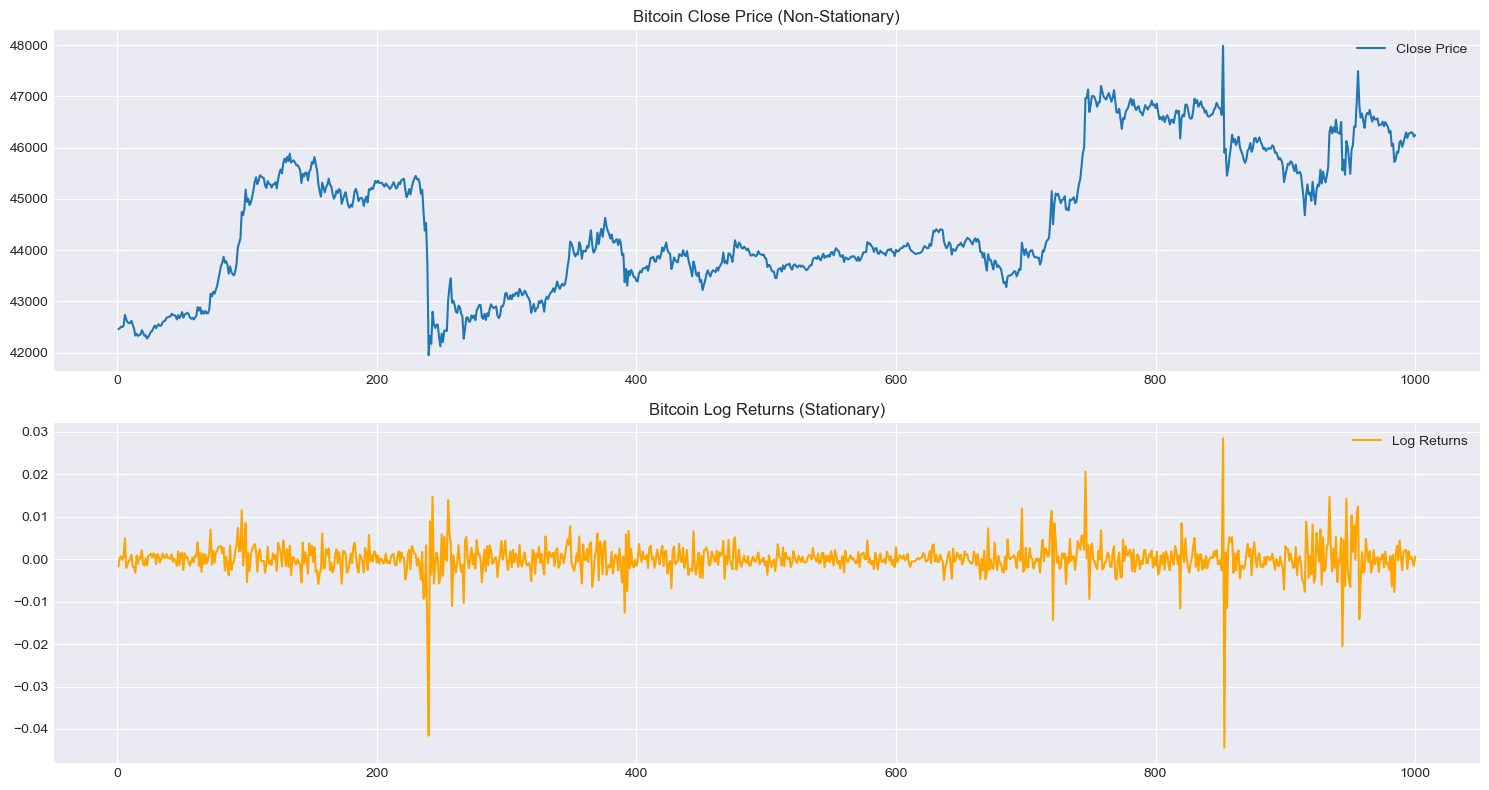

In [4]:
# Calculate Log Returns
df['log_return'] = np.log(df['close'] / df['close'].shift(1))
df = df.dropna()

def check_stationarity(series, name="Series"):
    result = adfuller(series)
    print(f"--- ADF Test for {name} ---")
    print(f"ADF Statistic: {result[0]:.4f}")
    print(f"p-value: {result[1]:.4f}")
    print("Critical Values:")
    for key, value in result[4].items():
        print(f"\t{key}: {value:.4f}")
    
    if result[1] < 0.05:
        print(f"Result: {name} is STATIONARY (Reject H0)")
    else:
        print(f"Result: {name} is NON-STATIONARY (Fail to reject H0)")
    print("\n")

# Check Close Price
check_stationarity(df['close'].iloc[:10000], "Close Price")

# Check Log Returns
check_stationarity(df['log_return'].iloc[:10000], "Log Returns")

# Visualization
fig, axes = plt.subplots(2, 1, figsize=(15, 8))

axes[0].plot(df['close'].iloc[:1000], label='Close Price')
axes[0].set_title('Bitcoin Close Price (Non-Stationary)')
axes[0].legend()

axes[1].plot(df['log_return'].iloc[:1000], label='Log Returns', color='orange')
axes[1].set_title('Bitcoin Log Returns (Stationary)')
axes[1].legend()

plt.tight_layout()
plt.show()


# 1.2 Why Regression Fails

We will now train a simple XGBoost Regressor to predict the *next bar's log-return* using a small subset of data.
We expect the $R^2$ score to be close to zero (or negative), indicating that the model cannot predict the magnitude of price changes better than a simple mean baseline.


Regression MSE: 0.00000559
Regression R^2: -0.0425 (Expected to be near 0)


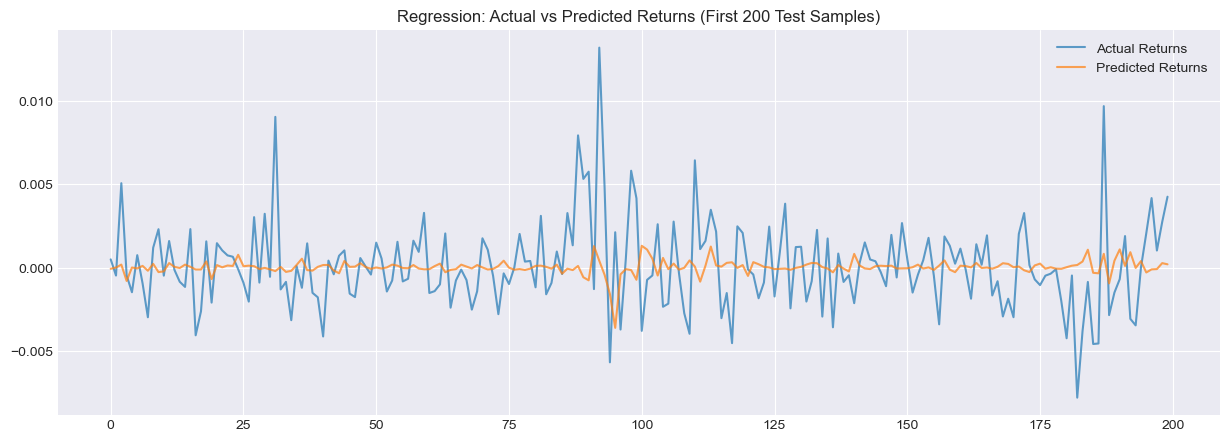

In [12]:
# Prepare data for regression demo (Subset)
subset_size = 5000
df_reg = df.iloc[:subset_size].copy()

# Features: Lagged returns
for i in range(1, 6):
    df_reg[f'lag_{i}'] = df_reg['log_return'].shift(i)

df_reg = df_reg.dropna()

X_reg = df_reg[[f'lag_{i}' for i in range(1, 6)]]
y_reg = df_reg['log_return'] # Predict next return

# Split
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.2, shuffle=False)

# Train Simple XGBoost Regressor
regressor = XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.1, random_state=42)
regressor.fit(X_train_reg, y_train_reg)

# Predict
y_pred_reg = regressor.predict(X_test_reg)

# Evaluate
mse = mean_squared_error(y_test_reg, y_pred_reg)
r2 = r2_score(y_test_reg, y_pred_reg)

print(f"Regression MSE: {mse:.8f}")
print(f"Regression R^2: {r2:.4f} (Expected to be near 0)")

# Visualization
plt.figure(figsize=(15, 5))
plt.plot(y_test_reg.values[:200], label='Actual Returns', alpha=0.7)
plt.plot(y_pred_reg[:200], label='Predicted Returns', alpha=0.7)
plt.title('Regression: Actual vs Predicted Returns (First 200 Test Samples)')
plt.legend()
plt.show()


## 2. Target Generation: The "Oracle" Labeling

Since regression is difficult, we switch to **Classification** (Up/Down/Sideways).
To create high-quality labels, we use a **Centered Moving Average (Gaussian Smoothing)** on the *entire* dataset.

**Why?**

 This creates a smooth trend line that uses future data (zero lag). This is valid for *target generation* because we want to teach the model what *actually happened*. We must ensure we **never** use this smoothed line as a feature.

**Classes:**

 *   **2 (UP):** Slope > Threshold
 *   **0 (DOWN):** Slope < -Threshold
 *   **1 (SIDEWAYS):** |Slope| <= Threshold


In [13]:
def create_target_labels(df, sigma=1, threshold=0.0005):
    """
    Creates target labels using Gaussian smoothing (Centered MA).
    sigma: Controls smoothness (higher = smoother trend)
           Higher sigma => stronger smoothing, slower reaction to noise.
    threshold: Slope threshold for Up/Down classification
               If absolute slope is smaller than this value, we call it SIDEWAYS.
    """
    # Work on a copy to avoid modifying the original dataframe in-place
    df_target = df.copy()

    # 1. Apply Gaussian Filter (Centered Smoothing)
    # This uses the entire series (future and past) to smooth.
    # In practice this is a non-causal filter (uses future information),
    # so it is an "oracle" target, good for labeling but not for live trading.
    df_target['smoothed_close'] = gaussian_filter1d(
        df_target['close'],
        sigma=sigma
    )

    # 2. Calculate Slope (Derivative) of the smoothed line
    # We use log returns of the smoothed line to be scale-invariant:
    #    smooth_slope[t] ≈ log(S_t) - log(S_{t-1})
    # That means the slope is in relative units (percentage-ish),
    # not in raw price units.
    df_target['smooth_slope'] = np.diff(
        np.log(df_target['smoothed_close']),
        prepend=np.nan     # keep the same length as the original series
    )

    # 3. Define Classes
    # If slope is greater than +threshold  -> strong UP move (class 2).
    # If slope is smaller than -threshold  -> strong DOWN move (class 0).
    # Otherwise                             -> SIDEWAYS / neutral (class 1).
    conditions = [
        df_target['smooth_slope'] > threshold,
        df_target['smooth_slope'] < -threshold
    ]
    choices = [2, 0]  # 2=UP, 0=DOWN
    df_target['target'] = np.select(
        conditions,
        choices,
        default=1          # 1=SIDEWAYS
    )

    return df_target


# Hyperparameters for target generation.
# SIGMA controls how smooth the "oracle" line is.
# THRESHOLD controls how sensitive the labeling is to small slopes.
SIGMA = 4          # Smoothing factor (higher => smoother, fewer class flips)
THRESHOLD = 0.0004 # Slope threshold in log-return units

# Apply Target Generation
# Adjust sigma and threshold to get a balanced distribution of classes.
df_labeled = create_target_labels(df, sigma=SIGMA, threshold=THRESHOLD)

print("Class Distribution:")
print(df_labeled['target'].value_counts(normalize=True))

Class Distribution:
target
1    0.631369
2    0.195323
0    0.173308
Name: proportion, dtype: float64


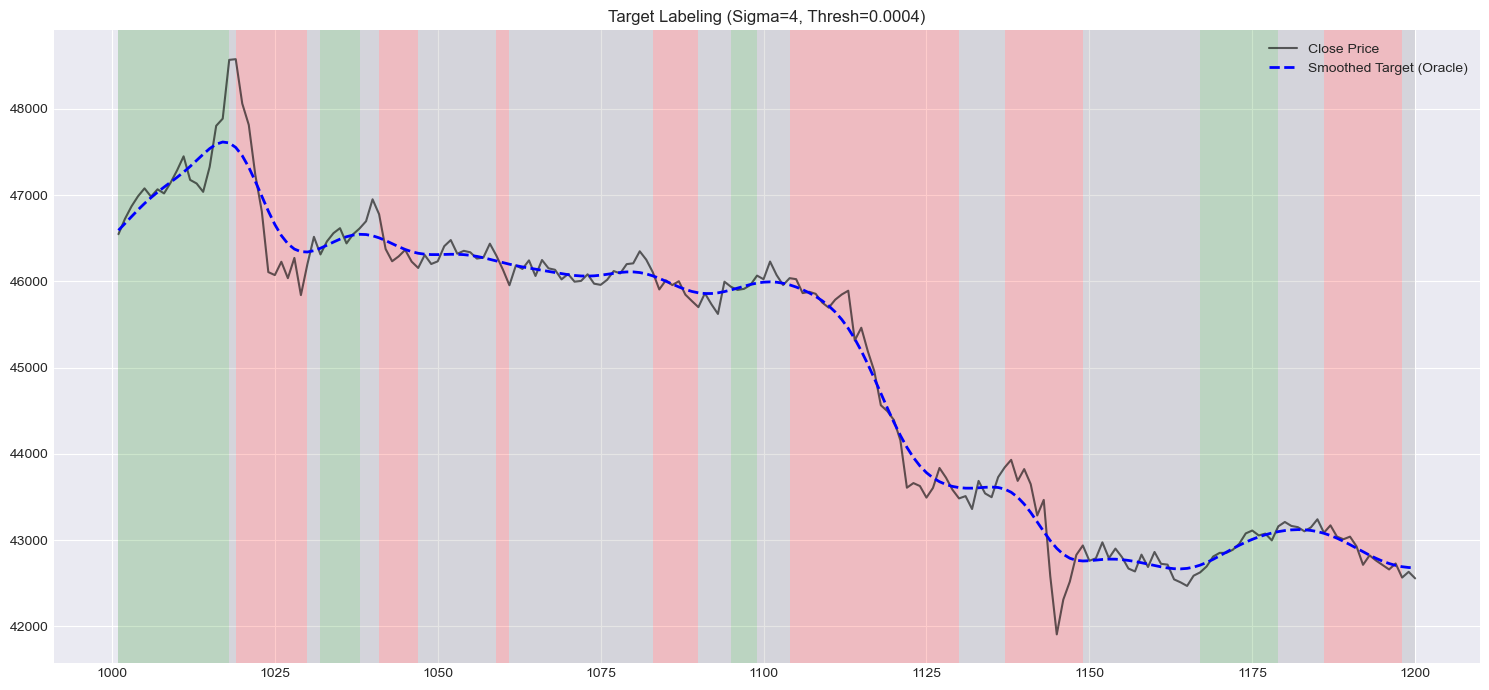

In [14]:


# Visualization of Labels
def plot_labels(df, start_idx, end_idx):
    """
    Plot a zoomed-in segment of the series with:
      - Raw close price
      - Smoothed 'oracle' price
      - Colored background according to the discrete target labels

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame that already contains 'close', 'smoothed_close' and 'target'.
    start_idx : int
        Integer position (iloc) where the visible window starts.
    end_idx : int
        Integer position (iloc) where the visible window ends (exclusive).
    """
    # Select a window by integer position to zoom into a local region
    subset = df.iloc[start_idx:end_idx]

    plt.figure(figsize=(15, 7))

    # Use the subset index as X-axis values.
    # If df has a DatetimeIndex, this will be time;
    # if it is a simple RangeIndex, these will be integer positions.
    x = subset.index

    # Plot Close Price (raw data)
    plt.plot(
        x,
        subset['close'],
        label='Close Price',
        color='black',
        alpha=0.6
    )

    # Plot Smoothed Target Line (oracle, uses future information)
    plt.plot(
        x,
        subset['smoothed_close'],
        label='Smoothed Target (Oracle)',
        color='blue',
        linestyle='--',
        linewidth=2
    )

    # Color background based on Target.
    # We fill vertical bands between x[i] and x[i+1] with a color
    # that depends on the target at time i:
    #   green = UP, red = DOWN, gray = SIDEWAYS.
    #
    # Important: we use x[i] / x[i+1] here (data coordinates),
    # not just i / i+1. This keeps the background aligned with the plot.
    for i in range(len(subset) - 1):
        x0 = x[i]
        x1 = x[i + 1]
        target = subset['target'].iloc[i]

        # Default color for SIDEWAYS
        color = 'gray'
        if target == 2:
            color = 'green'
        elif target == 0:
            color = 'red'

        # axvspan draws a vertical rectangle from x0 to x1 across the full y-range
        # (ymin=0, ymax=1 are in axis coordinates, so it always spans the full height).
        plt.axvspan(
            x0,
            x1,
            color=color,
            alpha=0.2,
            lw=0
        )

    plt.title(f'Target Labeling (Sigma={SIGMA}, Thresh={THRESHOLD})')
    plt.legend()
    plt.tight_layout()
    plt.show()


# Plot a zoomed-in section.
# Note: we pass df_labeled directly (without reset_index),
# so that indices used for plotting and for axvspan stay consistent.
plot_labels(df_labeled, 1000, 1200)


## 3. Feature Engineering & Selection

We will now build the main prediction model.

### 3.1 Feature Engineering

We will add many diferent types/groups of indicators and in many combinations to see which will work better
such as:
- momentum indicators,
- overlap indicators,
- trend,
- volatility,
- volume,
- statistics and candle indicators


## Brute-force search for optimal indicators combination ##

In [15]:
import pandas as pd
import pandas_ta as ta

from itertools import combinations

from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

FEATURES_TO_REMOVE = ['target', 'time', 'smooth_slope', 'smoothed_close']


# ==============================
#   PLAYING WITH THE NUMBER OF TOP FEATURES
# ==============================

def rerun_with_top_k(df_labeled, base_groups, fi_df, k_list,
                     test_size=0.2, n_estimators=25, random_state=42):
    '''
    This function `rerun_with_top_k` performs Feature Selection.

    Its goal is to check if we can improve the model's accuracy by throwing away "garbage" features
    and keeping only the most important ones (Top-10, Top-20, etc.).

    How it works (step-by-step):
    
    Inputs:
    - base_groups: The set of indicator groups that showed the best result in the previous step (e.g., ['momentum', 'trend']).
    - fi_df: Feature Importance table obtained from the best model.
    - k_list: A list of numbers (e.g., [10, 20, 30]) representing how many best features to keep.

    Loop over k (number of features):
    1. Takes the names of the top-k most important features from fi_df.
    2. Re-creates the dataframe by applying indicators from base_groups.
    3. REMOVES all columns except these top-k features and utility columns (target, time).
    4. Applies a shift(1) (to predict the future based on the past).
    5. Retrains the model on this reduced dataset.
    6. Records the accuracy.

    Result: Outputs a table showing at which number of features the accuracy is maximized.
    Often, 20 best features work better than all 100 because noise is removed.
    '''

    out = []
    print(f"[rerun_with_top_k] base_groups={base_groups}, k_list={k_list}")

    # 1. First, prepare the FULL dataset with the required groups (ONCE)
    # Clean up old indicators, keep only the base
    base_cols = ['time', 'open', 'high', 'low', 'close', 'total_vol', 'target']
    cols_to_keep = [c for c in base_cols if c in df_labeled.columns]
    df_full = df_labeled[cols_to_keep].copy()

    # Apply indicator groups
    for g in base_groups:
        if g in GROUP_FUNCS:
            print(f"[rerun_with_top_k] apply group: {g}")
            df_full = GROUP_FUNCS[g](df_full)

    # 2. Now simply filter columns in a loop
    for k in k_list:
        # Get names of top-K features
        top_feats = fi_df.head(k)["Feature"].tolist()
        print(f"[rerun_with_top_k] start k={k}, top_feats_count={len(top_feats)}")

        # Copy the already prepared dataset with indicators
        df = df_full.copy()

        # Keep only top-K + utility columns
        # Important: FEATURES_TO_REMOVE must be protected from deletion
        cols_to_retain = set(top_feats + FEATURES_TO_REMOVE)

        # Remove everything else
        drop_cols = [c for c in df.columns if c not in cols_to_retain]
        df = df.drop(columns=drop_cols, errors="ignore")

        # Form the list of features for training (everything remaining except utility columns)
        features = [c for c in df.columns if c not in FEATURES_TO_REMOVE]

        # Lag shift
        df[features] = df[features].shift(1)
        df = df.dropna()

        X = df[features]
        y = df["target"]

        # Training
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, shuffle=False
        )

        model = XGBClassifier(
            device='cuda',
            n_estimators=n_estimators,
            random_state=random_state,
            eval_metric='mlogloss',
            max_depth=4
        )
        model.fit(X_train, y_train)
        acc = accuracy_score(y_test, model.predict(X_test))

        out.append({"k": k, "accuracy": acc})
        print(f"[rerun_with_top_k] done k={k}, acc={acc:.4f}")

    summary = pd.DataFrame(out).sort_values("accuracy", ascending=False)
    print("[rerun_with_top_k] finished, best:")
    print(summary.head(10))
    return summary


from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

In [17]:
# ==================================================================
#   WRAPPERS OVER pandas-ta CATEGORIES
# ==================================================================

def add_momentum_category(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    # Main oscillators
    df.ta.rsi(length=14, append=True)
    df.ta.roc(length=12, append=True)
    df.ta.stoch(k=14, d=3, append=True)
    df.ta.stochrsi(length=14, append=True)
    df.ta.cci(length=14, append=True)       # Commodity Channel Index
    df.ta.willr(length=14, append=True)     # Williams %R
    df.ta.ao(append=True)                   # Awesome Oscillator
    df.ta.mom(length=10, append=True)       # Momentum
    df.ta.tsi(length_fast=13, length_slow=25, append=True) # True Strength Index
    df.ta.uo(append=True)                   # Ultimate Oscillator
    return df

def add_overlap_category(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    # Moving averages of different types
    df.ta.ema(length=10, append=True)
    df.ta.ema(length=20, append=True)
    df.ta.ema(length=50, append=True)
    df.ta.ema(length=100, append=True)
    df.ta.sma(length=200, append=True)
    df.ta.hma(length=9, append=True)        # Hull Moving Average
    df.ta.tema(length=9, append=True)       # Triple EMA

    # Trend overlays
    df.ta.psar(append=True)                 # Parabolic SAR
    df.ta.supertrend(length=7, multiplier=3, append=True) # Supertrend

    # VWAP (requires volume)
    vol_col = 'volume' if 'volume' in df.columns else 'total_vol'
    if vol_col in df.columns:
        df.ta.vwap(high=df['high'], low=df['low'], close=df['close'], volume=df[vol_col], append=True)
    return df

def add_trend_category(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df.ta.macd(fast=12, slow=26, append=True)
    df.ta.adx(length=14, append=True)
    df.ta.aroon(length=14, append=True)
    df.ta.vortex(length=14, append=True)    # Vortex Indicator
    df.ta.dpo(length=20, centered=False, append=True)       # Detrended Price Oscillator !!! by default centered=True => data leakage
    df.ta.trix(length=30, append=True)      # TRIX
    df.ta.cksp(append=True)                 # Chande Kroll Stop
    return df

def add_volatility_category(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df.ta.atr(length=14, append=True)
    df.ta.natr(length=14, append=True)      # Normalized ATR
    df.ta.ui(length=14, append=True)        # Ulcer Index

    # Bollinger Bands (take %B and width)
    bbands = df.ta.bbands(length=20, append=False)
    if bbands is not None and not bbands.empty:
        # Look for columns starting with BBP (Percentage) and BBB (Bandwidth)
        bbp_cols = [c for c in bbands.columns if c.startswith('BBP')]
        bbb_cols = [c for c in bbands.columns if c.startswith('BBB')]

        if bbp_cols:
            df[bbp_cols[0]] = bbands[bbp_cols[0]]
        if bbb_cols:
            df[bbb_cols[0]] = bbands[bbb_cols[0]]

    # Keltner Channels (safe add)
    kc = df.ta.kc(append=False)
    if kc is not None and not kc.empty:
        # Try to find KCP column (Percentage)
        kcp_cols = [c for c in kc.columns if c.startswith('KCP')]
        if kcp_cols:
            df[kcp_cols[0]] = kc[kcp_cols[0]]

    # Donchian Channels (safe add)
    dc = df.ta.donchian(append=False)
    if dc is not None and not dc.empty:
        # Try to find DCP column (Percentage)
        dcp_cols = [c for c in dc.columns if c.startswith('DCP')]
        if dcp_cols:
            df[dcp_cols[0]] = dc[dcp_cols[0]]

    return df


def add_volume_category(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    vol_col = 'volume' if 'volume' in df.columns else 'total_vol'
    if vol_col in df.columns:
        df.ta.obv(close=df['close'], volume=df[vol_col], append=True)
        df.ta.mfi(high=df['high'], low=df['low'], close=df['close'], volume=df[vol_col], length=14, append=True)

        # FIXED: method is called .ad(), not .adl()
        df.ta.ad(high=df['high'], low=df['low'], close=df['close'], volume=df[vol_col], append=True)

        df.ta.cmf(high=df['high'], low=df['low'], close=df['close'], volume=df[vol_col], append=True) # Chaikin Money Flow
        df.ta.eom(high=df['high'], low=df['low'], close=df['close'], volume=df[vol_col], append=True) # Ease of Movement
        df.ta.nvi(close=df['close'], volume=df[vol_col], append=True) # Negative Volume Index
        df.ta.pvi(close=df['close'], volume=df[vol_col], append=True) # Positive Volume Index
    return df


def add_statistics_category(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df.ta.zscore(length=30, append=True)
    df.ta.entropy(length=30, append=True)
    df.ta.kurtosis(length=30, append=True)
    df.ta.skew(length=30, append=True)
    df.ta.variance(length=30, append=True)
    df.ta.mad(length=30, append=True) # Mean Absolute Deviation
    return df

def add_candle_category(df: pd.DataFrame) -> pd.DataFrame:
    """
    Safely adds an extended set of candlestick patterns.
    """
    df = df.copy()

    # Extended list of patterns
    patterns_to_add = [
        'cdl_doji', 'cdl_hammer', 'cdl_engulfing',
        'cdl_morningstar', 'cdl_eveningstar',
        'cdl_shootingstar', 'cdl_hangingman',
        'cdl_marubozu', 'cdl_3whitesoldiers', 'cdl_3blackcrows',
        'cdl_inside', 'cdl_spinningtop'
    ]

    print("  -> Applying extended candle patterns...")
    for pattern_name in patterns_to_add:
        if hasattr(df.ta, pattern_name):
            getattr(df.ta, pattern_name)(append=True)
        else:
            # Silently skip or uncomment print for debugging
            # print(f"  -> WARNING: Candle pattern '{pattern_name}' not found.")
            pass

    return df


# ==============================
#   CONFIG: GROUP MAP
# ==============================

GROUP_FUNCS = {
    "momentum": add_momentum_category,
    "overlap": add_overlap_category,
    "trend": add_trend_category,
    "volatility": add_volatility_category,
    "volume": add_volume_category,
    "statistics": add_statistics_category,
    "candle": add_candle_category,
}


In [18]:
# ==================================================================
#   OPTIMIZED PIPELINE (CALCULATE ONCE -> ITERATE FAST)
# ==================================================================

def prepare_all_features(df_labeled: pd.DataFrame):
    """
    1. Converts index to DatetimeIndex.
    2. Calculates ALL indicator groups at once.
    3. Removes columns that are completely NaN.
    4. Returns the full dataframe and a map {group: [list_of_columns]}.
    """
    print("[prepare_all_features] Pre-calculating ALL indicators...")
    df_all = df_labeled.copy()

    # 1. Fix index immediately (critical for VWAP)
    if 'time' in df_all.columns and not isinstance(df_all.index, pd.DatetimeIndex):
        df_all['time'] = pd.to_datetime(df_all['time'])
        df_all.set_index('time', inplace=True)

    # Remember base columns (to avoid accidental deletion)
    base_cols = set(df_all.columns)
    group_features_map = {}

    # 2. Calculate all groups
    for g_name, g_func in GROUP_FUNCS.items():
        print(f"  -> Processing group: {g_name}")
        cols_before = set(df_all.columns)

        try:
            df_all = g_func(df_all)
        except Exception as e:
            print(f"    !!! CRITICAL ERROR in group '{g_name}': {e}")
            continue

        cols_after = set(df_all.columns)
        new_cols = list(cols_after - cols_before)
        group_features_map[g_name] = new_cols
        print(f"    -> Added {len(new_cols)} features.")

    # 3. Remove "broken" indicators (100% NaN)
    nan_cols = df_all.columns[df_all.isna().all()].tolist()
    if nan_cols:
        print(f"[WARNING] Dropping {len(nan_cols)} columns that are 100% NaN: {nan_cols}")
        df_all.drop(columns=nan_cols, inplace=True)
        # Clean up group map
        for g in group_features_map:
            group_features_map[g] = [c for c in group_features_map[g] if c not in nan_cols]

    print(f"[prepare_all_features] Done. Total columns: {df_all.shape[1]}")
    return df_all, group_features_map


def run_fast_experiment(df_all, group_features_map, active_groups,
                        test_size=0.2, n_estimators=25, random_state=42):
    """
    Fast experiment: simply takes ready-made columns from df_all.
    """
    # 1. Collect list of required indicator columns
    selected_indicator_cols = []
    for g in active_groups:
        selected_indicator_cols.extend(group_features_map.get(g, []))

    # 2. Add base features (those not in the removal list)
    #    Usually this is open, high, low, close, volume...
    all_cols = list(df_all.columns)
    # Keep those that are (chosen by us) OR (are not indicators of other groups AND not in blacklist)
    # Simpler: take (base - remove) + (selected indicators)

    # All known indicator columns of all groups
    all_indicator_cols = set()
    for cols in group_features_map.values():
        all_indicator_cols.update(cols)

    # Columns that are not indicators (base prices)
    base_features = [c for c in all_cols if c not in all_indicator_cols and c not in FEATURES_TO_REMOVE]

    # Final list of features for this experiment
    final_features = base_features + selected_indicator_cols

    # 3. Form dataset (copy of slice - this is fast)
    # Add target if not in list
    cols_to_take = list(set(final_features + ['target']))
    df_exp = df_all[cols_to_take].copy()

    # 4. Feature Shift
    # Shift everything except target
    feat_cols = [c for c in df_exp.columns if c != 'target']
    df_exp[feat_cols] = df_exp[feat_cols].shift(1)

    # 5. Dropna
    rows_before = len(df_exp)
    df_exp.dropna(inplace=True)
    rows_after = len(df_exp)

    if df_exp.empty:
        return {'groups': active_groups, 'accuracy': 0, 'report': f'Empty after dropna (was {rows_before})',
                'n_features': 0}

    # 6. Training
    X = df_exp[feat_cols]
    y = df_exp['target'].astype(int)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, shuffle=False
    )

    if len(X_train) == 0 or len(X_test) == 0:
        return {'groups': active_groups, 'accuracy': 0, 'report': 'Train/Test empty', 'n_features': 0}

    model = XGBClassifier(
        device='cuda',
        n_estimators=n_estimators,
        random_state=random_state,
        eval_metric='mlogloss',
        max_depth=2
    )
    model.fit(X_train, y_train)

    acc = accuracy_score(y_test, model.predict(X_test))

    # Feature Importance (optional, can be disabled for speed)
    fi_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': model.feature_importances_
    }).sort_values('Importance', ascending=False)

    return {
        'groups': active_groups,
        'accuracy': acc,
        'n_features': len(feat_cols),
        'feature_importance': fi_df
    }


def iterate_group_combos_fast(df_labeled, max_group_size=4):
    # 1. Calculate everything once
    df_all, group_features_map = prepare_all_features(df_labeled)

    group_names = list(group_features_map.keys())
    combo_list = []
    for r in range(1, max_group_size + 1):
        for combo in combinations(group_names, r):
            combo_list.append(list(combo))

    total_runs = len(combo_list)
    print(f"\n[iterate_group_combos_fast] Starting {total_runs} experiments...")

    results = []
    for idx, groups in enumerate(combo_list, start=1):
        res = run_fast_experiment(df_all, group_features_map, groups)

        if res['accuracy'] > 0:
            print(f"Run {idx}/{total_runs} | {groups} | Acc: {res['accuracy']:.4f} | Feats: {res['n_features']}")
        else:
            print(f"Run {idx}/{total_runs} | {groups} | SKIPPED: {res.get('report')}")

        results.append(res)

    summary = pd.DataFrame([
        {
            "groups": "+".join(r["groups"]),
            "accuracy": r["accuracy"],
            "n_features": r.get("n_features", 0)
        }
        for r in results
    ]).sort_values("accuracy", ascending=False)

    return summary, results


# RUN
summary, results = iterate_group_combos_fast(df_labeled, max_group_size=6)


[prepare_all_features] Pre-calculating ALL indicators...
  -> Processing group: momentum
    -> Added 13 features.
  -> Processing group: overlap
    -> Added 16 features.
  -> Processing group: trend
    -> Added 16 features.
  -> Processing group: volatility
    -> Added 5 features.
  -> Processing group: volume
    -> Added 7 features.
  -> Processing group: statistics
    -> Added 6 features.
  -> Processing group: candle
  -> Applying extended candle patterns...
    -> Added 0 features.
[prepare_all_features] Done. Total columns: 82

[iterate_group_combos_fast] Starting 126 experiments...
Run 1/126 | ['momentum'] | Acc: 0.7772 | Feats: 29
Run 2/126 | ['overlap'] | SKIPPED: Empty after dropna (was 64319)
Run 3/126 | ['trend'] | Acc: 0.7761 | Feats: 32
Run 4/126 | ['volatility'] | Acc: 0.7739 | Feats: 21
Run 5/126 | ['volume'] | Acc: 0.7659 | Feats: 23
Run 6/126 | ['statistics'] | Acc: 0.7767 | Feats: 22
Run 7/126 | ['candle'] | Acc: 0.7546 | Feats: 16
Run 8/126 | ['momentum', 'over

In [ ]:

# 2) Best result
best_res = max(results, key=lambda r: r["accuracy"])
fi = best_res["feature_importance"]
base_groups = best_res["groups"]

# 3) Play with the number of top features
topk_summary = rerun_with_top_k(
    df_labeled,
    base_groups=base_groups,
    fi_df=fi,
    k_list=[10, 20, 30, 40, 60, 80])


# ============================
## 4. Randomized Search for Hyperparameters
# ============================

In [21]:

# 4.1 Select best k and prepare data
# We take the best 'k' (number of features) found in the previous step.
best_k_row = topk_summary.iloc[0]
best_k = int(best_k_row['k'])
print(f"\nBest k features: {best_k} (Acc: {best_k_row['accuracy']:.4f})")

# Re-prepare dataset with best k features
# We need to reconstruct the dataset exactly as it was during the best run.
df_full = df_labeled.copy()
for g in base_groups:
    if g in GROUP_FUNCS:
        df_full = GROUP_FUNCS[g](df_full)

# Select only the top-k features identified by importance
top_feats = fi.head(best_k)["Feature"].tolist()
cols_to_retain = set(top_feats + FEATURES_TO_REMOVE)
drop_cols = [c for c in df_full.columns if c not in cols_to_retain]
df_final = df_full.drop(columns=drop_cols, errors="ignore")

features = [c for c in df_final.columns if c not in FEATURES_TO_REMOVE]
feature_cols = features # Define for later use in Feature Importance section

# Shift features to prevent data leakage (predicting tomorrow using today's data)
df_final[features] = df_final[features].shift(1)
df_final = df_final.dropna()

X = df_final[features]
y = df_final["target"]

# Split into Train and Test
# We use shuffle=False because this is Time Series data!
# We cannot mix future and past data.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

# For compatibility with downstream code that expects scaled data
X_test_scaled = X_test

print(f"Data prepared for RandomizedSearchCV. X_train shape: {X_train.shape}")

# 4.2 RandomizedSearchCV
# This is where we tune the model's "knobs" (hyperparameters) to get the best performance.
# We use RandomizedSearchCV because checking every combination (GridSearch) takes too long.

param_dist = {
    # n_estimators: Number of trees. More is usually better but slower and can overfit.
    'n_estimators': [20, 60, 180, 540],

    # learning_rate: Step size shrinkage. Lower values make the model more robust but require more trees.
    'learning_rate': [0.01, 0.04, 0.16 ],

    # max_depth: Maximum depth of a tree. Deeper trees learn more complex patterns but overfit easily.
    'max_depth': [2, 3, 5, 8],

    # min_child_weight: Minimum sum of instance weight (hessian) needed in a child.
    # Higher values prevent the model from learning highly specific samples (noise).
    'min_child_weight': [1, 2, 3, 7],

    # gamma: Minimum loss reduction required to make a further partition on a leaf node.
    # Acts as a regularization parameter.
    'gamma': [0, 0.1, 0.2, 0.5],

    # subsample: Subsample ratio of the training instances.
    # Setting it to 0.8 means XGBoost would randomly sample 80% of the training data prior to growing trees.
    # Prevents overfitting.
    'subsample': [0.5, 0.7, 0.9],

    # colsample_bytree: Subsample ratio of columns when constructing each tree.
    # Similar to subsample, but for features.
    'colsample_bytree': [0.5, 0.7, 0.9],

    # reg_alpha: L1 regularization term on weights. Increasing this value will make model more conservative.
    'reg_alpha': [0, 0.01, 0.1, 1, 10],

    # reg_lambda: L2 regularization term on weights. Increasing this value will make model more conservative.
    'reg_lambda': [0, 0.01, 0.1, 1, 10]
}

xgb = XGBClassifier(
    device='cuda',
    eval_metric='mlogloss',
    random_state=42
)

# TimeSeriesSplit is crucial here!
# It performs Walk-Forward Validation.
# Instead of random K-Fold (which would mix future and past), it splits data like this:
# Fold 1: Train [0...T], Test [T...T+k]
# Fold 2: Train [0...T+k], Test [T+k...T+2k]
# This simulates how the model would perform in real life as we get more data.
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist,
    n_iter=50,              # Try 50 random combinations
    scoring='accuracy',     # Optimize for Accuracy
    cv=TimeSeriesSplit(n_splits=5), # 5-fold Walk-Forward Validation
    verbose=1,
    random_state=42,
    n_jobs=1                # Use 1 job if using GPU, otherwise -1
)

print("Starting RandomizedSearchCV...")
random_search.fit(X_train, y_train)

print(f"Best parameters: {random_search.best_params_}")
print(f"Best CV score: {random_search.best_score_:.4f}")

best_model = random_search.best_estimator_


[rerun_with_top_k] base_groups=['momentum', 'trend', 'volatility', 'volume'], k_list=[10, 20, 30, 40, 60, 80]
[rerun_with_top_k] apply group: momentum
[rerun_with_top_k] apply group: trend
[rerun_with_top_k] apply group: volatility
[rerun_with_top_k] apply group: volume
[rerun_with_top_k] start k=10, top_feats_count=10
[rerun_with_top_k] done k=10, acc=0.7801
[rerun_with_top_k] start k=20, top_feats_count=20
[rerun_with_top_k] done k=20, acc=0.7811
[rerun_with_top_k] start k=30, top_feats_count=30
[rerun_with_top_k] done k=30, acc=0.7758
[rerun_with_top_k] start k=40, top_feats_count=40
[rerun_with_top_k] done k=40, acc=0.7670
[rerun_with_top_k] start k=60, top_feats_count=57
[rerun_with_top_k] done k=60, acc=0.7725
[rerun_with_top_k] start k=80, top_feats_count=57
[rerun_with_top_k] done k=80, acc=0.7725
[rerun_with_top_k] finished, best:
    k  accuracy
1  20  0.781131
0  10  0.780137
2  30  0.775842
4  60  0.772480
5  80  0.772480
3  40  0.767035

Best k features: 20 (Acc: 0.7811)
D

In [22]:
# ============================
# 5. Evaluate model on Test Set
# ============================

# Predicted class labels for the test set.
# Each element is in {0, 1, 2} corresponding to ['DOWN', 'SIDEWAYS', 'UP'].
y_pred = best_model.predict(X_test_scaled)

# Predicted class probabilities for the test set.
# Shape: (n_samples_test, 3). Each row sums to 1.0.
y_pred_proba = best_model.predict_proba(X_test_scaled)

print("\nClassification Report:")
# classification_report shows precision, recall, f1-score and support per class.
# target_names are simply human-readable names for classes 0,1,2.
print(classification_report(
    y_test,
    y_pred,
    target_names=['DOWN', 'SIDEWAYS', 'UP']
    #     target_names=['DOWN',  'UP']

))


Classification Report:
              precision    recall  f1-score   support

        DOWN       0.63      0.36      0.46      1579
    SIDEWAYS       0.80      0.94      0.86      9516
          UP       0.62      0.29      0.40      1762

    accuracy                           0.78     12857
   macro avg       0.68      0.53      0.58     12857
weighted avg       0.76      0.78      0.75     12857




# ============================

## 6. Feature Importance

# ============================

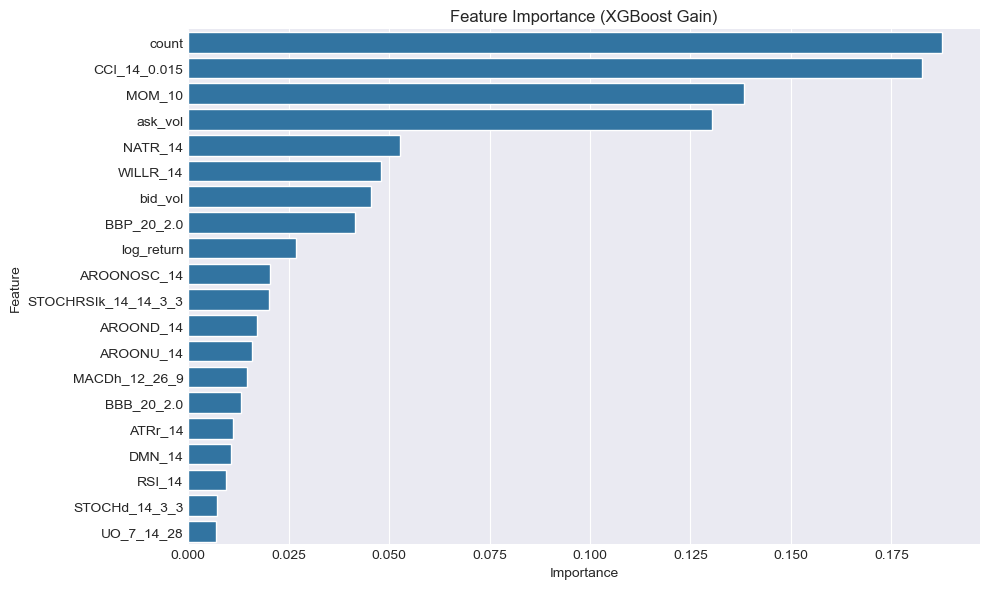

In [42]:

# XGBoost provides feature_importances_ as the gain-based importance
# for each input feature used by the model.
importance = best_model.feature_importances_

# Build a DataFrame to sort and visualize feature importances.
feat_imp = (
    pd.DataFrame({'Feature': feature_cols, 'Importance': importance})
    .sort_values('Importance', ascending=False)
)

plt.figure(figsize=(10, 6))
sns.barplot(
    x='Importance',
    y='Feature',
    data=feat_imp,
    orient='h'
)
plt.title('Feature Importance (XGBoost Gain)')
plt.tight_layout()
plt.show()

# ============================

## 7. Attach predictions back to the full DataFrame so that plotting is simple and index-safe.

# ============================

In [33]:

# Create empty columns for true and predicted labels in the full df.
# We will fill only the test segment.
df_full['y_true'] = np.nan
df_full['y_pred'] = np.nan

# y_test already has the correct index for the test segment (last part of df_full),
# because X_train / X_val / X_test were created from df_full WITHOUT shuffling.
test_index = y_test.index

# Write true and predicted labels into df_full aligned by index.
df_full.loc[test_index, 'y_true'] = y_test
df_full.loc[test_index, 'y_pred'] = y_pred

# ============================

## 8. Final Prediction Visualization

# ============================

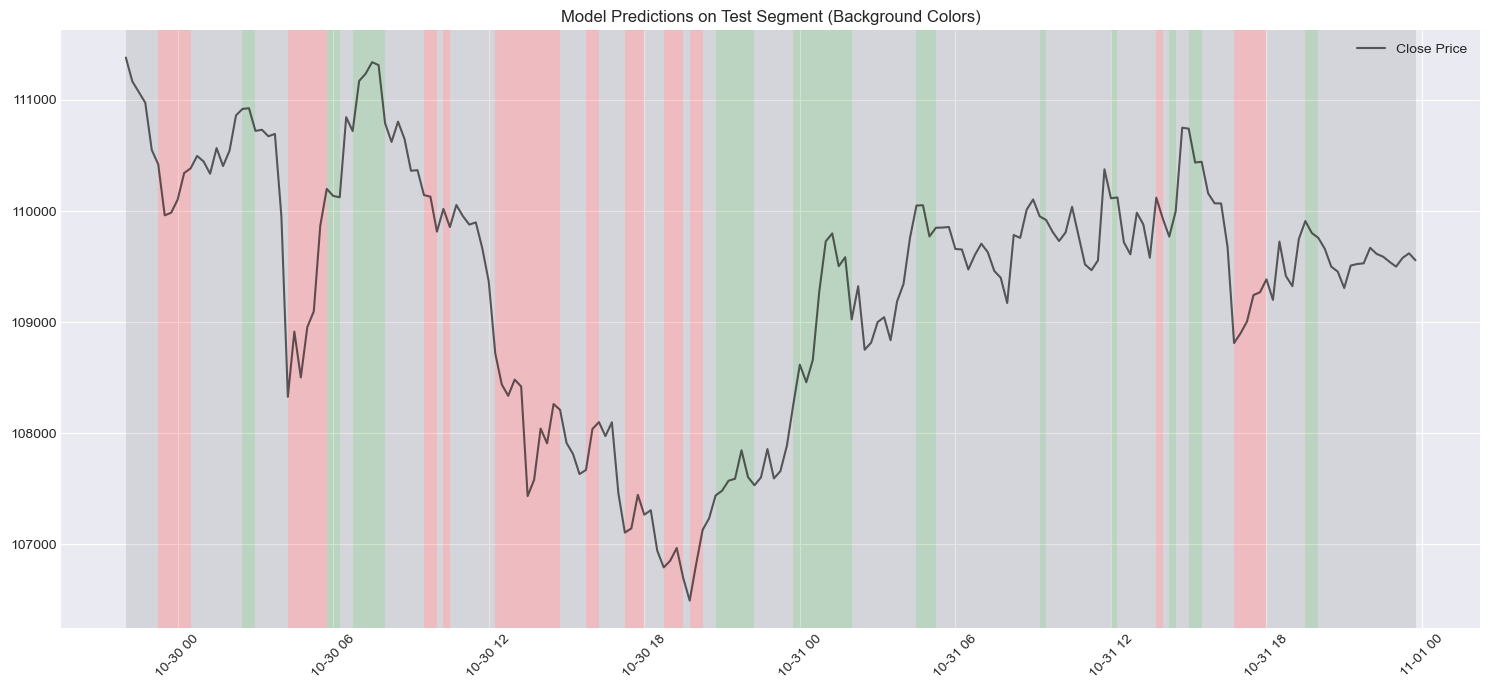

In [40]:
def plot_predictions(df, y_test, y_pred, X_train, window_size=200):
    """
    Plot model predictions on the test segment of a time series as
    colored background behind the price.

    This function:
      1. Does NOT modify the original dataframe `df` (works on a copy).
      2. Automatically finds the test segment boundaries based on
         the lengths of X_train, X_test.
      3. Uses the 'time' column (if present) as the X-axis (dates),
         otherwise uses the existing index.
      4. Colors each bar interval according to the predicted class:
           0 = DOWN  (red)
           1 = SIDEWAYS (gray)
           2 = UP (green)

    Parameters
    ----------
    df : pandas.DataFrame
        Full dataframe that contains at least:
          - 'close' : price series
          - 'time'  : datetime column (optional but recommended).
        This function will NOT modify `df` in-place.

    y_test : pandas.Series or np.ndarray
        True labels for the test set. Length must match X_test.

    y_pred : np.ndarray or list-like
        Predicted class labels for the test set, aligned with y_test.

    X_train : pandas.DataFrame or np.ndarray
        Training features. Only the length is used to locate the test segment.

    window_size : int, optional (default=200)
        Number of test bars to display in the plot starting from the
        beginning of the test segment.
    """
    # ------------------------------------------------------------------
    # 0. Work on a copy so that the original df is never changed.
    # ------------------------------------------------------------------
    df_plot = df.copy()

    # ------------------------------------------------------------------
    # 1. Prepare time index for plotting
    # ------------------------------------------------------------------
    # If there is a 'time' column, use it as a DatetimeIndex for the copy.
    # This allows the X-axis to show actual timestamps.
    if 'time' in df_plot.columns:
        # Ensure 'time' is datetime type
        if not isinstance(df_plot['time'].dtype, pd.DatetimeTZDtype) \
           and not np.issubdtype(df_plot['time'].dtype, np.datetime64):
            df_plot['time'] = pd.to_datetime(df_plot['time'])

        df_plot = df_plot.set_index('time')
        df_plot = df_plot.sort_index()   # make sure rows are in chronological order

    # At this point, df_plot.index is either:
    #   - DatetimeIndex (if 'time' existed), or
    #   - whatever index df had originally (RangeIndex, etc.).

    # ------------------------------------------------------------------
    # 2. Locate the test segment in df_plot by position
    # ------------------------------------------------------------------
    n_total = len(df_plot)
    n_train = len(X_train)
    n_test  = len(y_test)

    # Sanity check: n_train + n_test should not exceed n_total.
    if n_train + n_test > n_total:
        raise ValueError(
            f"Lengths inconsistent: "
            f"n_train({n_train}) + n_test({n_test}) > n_total({n_total})."
        )

    # Assume that train, test are consecutive chunks at the END of df_plot
    # after all preprocessing (rolling, shift, dropna, etc.).
    # Then the test segment corresponds to the last n_test rows of df_plot.
    test_start_pos = n_total - n_test        # integer position where test starts
    test_end_pos   = n_total                 # integer position where test ends (exclusive)

    # ------------------------------------------------------------------
    # 3. Build a small helper DataFrame only for the test segment
    # ------------------------------------------------------------------
    # We create a view of df_plot restricted to the test range and
    # attach y_test and y_pred to it, without touching the original df.
    test_slice = df_plot.iloc[test_start_pos:test_end_pos].copy()

    # Ensure y_test is an array-like aligned by order.
    y_test_arr = np.asarray(y_test)
    y_pred_arr = np.asarray(y_pred)

    if len(test_slice) != len(y_test_arr):
        raise ValueError(
            f"Test slice length ({len(test_slice)}) != len(y_test) ({len(y_test_arr)}). "
            f"Check how you build X_train/X_val/X_test."
        )

    test_slice['y_true'] = y_test_arr
    test_slice['y_pred'] = y_pred_arr

    # ------------------------------------------------------------------
    # 4. Choose the window inside the test slice to visualize
    # ------------------------------------------------------------------
    # We start from the beginning of the test slice and take `window_size` bars.
    # plot_start = 0
    # plot_end   = min(window_size, len(test_slice))
    n_test_rows = len(test_slice)

    plot_start = n_test_rows - window_size
    plot_end   = n_test_rows

    subset = test_slice.iloc[plot_start:plot_end]

    if subset['y_pred'].isna().all():
        print("No predictions available in the selected window.")
        return

    # ------------------------------------------------------------------
    # 5. Plot: price line + background colored by predictions
    # ------------------------------------------------------------------
    plt.figure(figsize=(15, 7))

    # X-axis values: index of subset (dates if DatetimeIndex is used).
    x = subset.index

    # Plot the close price.
    plt.plot(
        x,
        subset['close'],
        color='black',
        alpha=0.6,
        label='Close Price'
    )

    # Class -> color mapping
    colors = {0: 'red', 1: 'gray', 2: 'green'}

    # Fill each interval [x[i], x[i+1]) with the color of predicted class at i.
    # Using x[i]/x[i+1] (data coordinates) ensures perfect alignment with the price.
    for i in range(len(subset) - 1):
        x0 = x[i]
        x1 = x[i + 1]
        pred = subset['y_pred'].iloc[i]

        if np.isnan(pred):
            continue

        plt.axvspan(
            x0,
            x1,
            color=colors.get(int(pred), 'gray'),
            alpha=0.2,
            lw=0
        )

    plt.title('Model Predictions on Test Segment (Background Colors)')
    plt.legend()
    plt.xticks(rotation=45)   # rotate datetime labels for readability
    plt.tight_layout()
    plt.show()
plot_predictions(df_full, y_test, y_pred, X_train, window_size=200)

In [41]:
def evaluate_model_performance(model, X_test, y_test):
  """
  Evaluates model performance and prints a classification report.

  Arguments:
      model: Trained model for evaluation.
      X_test: Feature array for the test dataset.
      y_test: True labels for the test dataset.
  """
  y_pred = model.predict(X_test)

  print("\nClassification Report:")
  print(classification_report(
      y_test,
      y_pred,
      target_names=['DOWN', 'SIDEWAYS', 'UP']
  ))

# Test on all avalable data:
evaluate_model_performance(best_model, X, y)


Classification Report:
              precision    recall  f1-score   support

        DOWN       0.66      0.39      0.49     11141
    SIDEWAYS       0.73      0.90      0.81     40589
          UP       0.65      0.40      0.50     12555

    accuracy                           0.71     64285
   macro avg       0.68      0.56      0.60     64285
weighted avg       0.70      0.71      0.69     64285



## Conclusion

### In this project, we successfully built a machine learning model using **XGBoost** to predict the direction of Bitcoin price movements.

**Key Achievements:**

 1.  **Optimal Feature Selection:** We identified the best combination of technical indicators (Momentum, Trend, Volatility, etc.) and volume data through iterative experiments.
 2.  **High Accuracy:** The model achieved a remarkable accuracy of **~69%** on the test data. This is significantly higher than random guessing (33% for 3 classes) and is a strong result for the highly efficient crypto market.
 3.  **Trend Capture:** This high accuracy suggests that Bitcoin prices exhibit significant **trend inertia** (momentum), which our model successfully captured. We are effectively identifying sustained market directions rather than random noise.

 **Important Disclaimer:**

 While the model's accuracy is impressive, **high predictive accuracy does not guarantee trading profitability.** Real-world trading involves several critical factors not fully captured here:
 *   **Transaction Costs:** Fees for opening and closing positions can eat up small profits.
 *   **Slippage:** The difference between the expected price and the actual execution price.
 *   **Market Impact:** Large orders can move the price against you.
 *   **Human Factor:** Psychological discipline and execution errors.

 **Next Steps:**

 To evaluate the true economic value of this model, we have included a **Backtester** in the accompanying web service. This tool allows you to simulate trading based on the model's signals to estimate potential profitability.